# Navarro-Frank-White halo potential

In [1]:
import os
from math import pi

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord


import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, NFWParams, PlummerParams, NFW_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot, plot_sky_projection
from odisseo.potentials import NFW 

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Plummer Sphere

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [3]:
# Define the 
config = SimulationConfig(N_particles=10_000, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1000, 
                          external_accelerations=(NFW_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC_MATRIX,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                 r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                 c = 10,),
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=10000, dimensions=3, return_snapshots=True, num_snapshots=100, fixed_timestep=True, num_timesteps=1000, softening=np.float64(0.010000000000000002), integrator=0, acceleration_scheme=2, batch_size=10000, double_map=False, external_accelerations=(0,))
SimulationParams(G=1, t_end=np.float64(6.7070874092034565), Plummer_params=PlummerParams(a=np.float64(0.1), Mtot=np.float64(1.0)), NFW_params=NFWParams(Mvir=np.float64(10000.0), r_s=np.float64(2.0), c=10, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28))


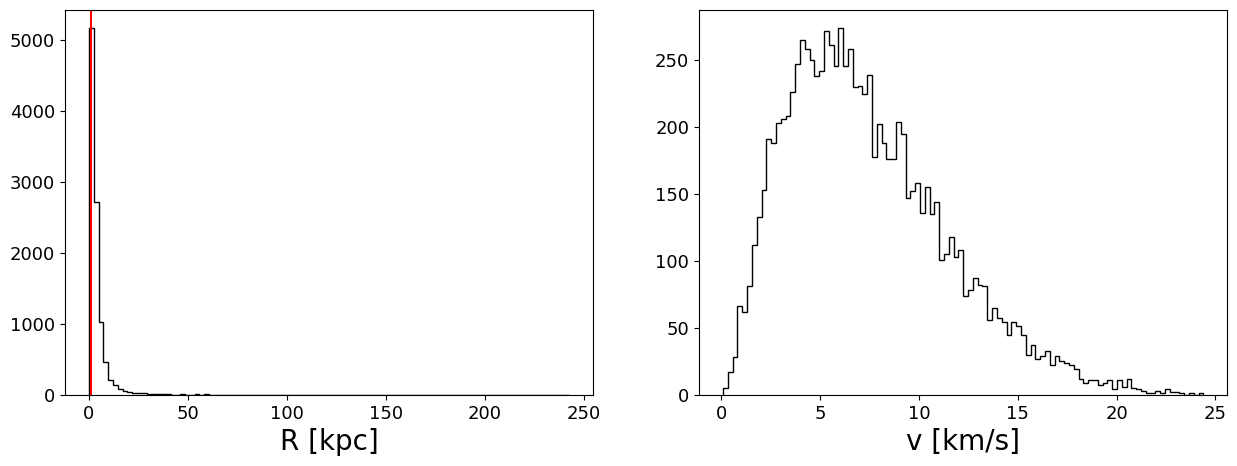

In [4]:
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


In [5]:
#put the Plummer sphere in a ciruclar orbit around the NFW halo
rp=100*u.kpc.to(code_units.code_length)

# mass_inside_rp = 4*jnp.pi*params.NFW_params.d_c*params.NFW_params.r_s**3*(jnp.log(1+rp/params.NFW_params.r_s)-rp/(rp+params.NFW_params.r_s))

# if len(config.external_accelerations)>0:
#     pos, vel, _ = ic_two_body(mass_inside_rp, params.Plummer_params.Mtot, rp=rp, e=0., config=config, params=params)
#     velocities = velocities + vel[1]
#     positions = positions + pos[1]

#sampling the center of mass on the sphere
key = random.PRNGKey(42)
num_samples = 1  # Number of positions to generate
pos = sample_position_on_circle(key, rp, num_samples)
inclination = jnp.radians(40)  # 30-degree inclination
pos = inclined_position(pos, inclination)
vel = jnp.zeros_like(pos)  # Initialize velocities to zero, it dosen't matter because the acceleration of MyamotoNagai depend only on the postion
state_com = construct_initial_state(pos, vel)

# Calculate the acceleration at the center of mass
acc_com, _ = NFW(state_com, config, params, return_potential=True)
#circular velocity at the center of mass
v_c = jnp.sqrt(jnp.linalg.norm(acc_com, axis=1) * rp)

#bulk motion to give to each particle of the Plummer sphere
vel = inclined_circular_velocity(pos, v_c, inclination)

print("Sampled Positions:\n", pos)
print("Corresponding Velocities:\n", vel)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos
velocities = velocities + vel


#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

Sampled Positions:
 [[0.89916889 7.62941406 6.40183852]]
Corresponding Velocities:
 [-25.19794374   2.27493586   1.90889784]


In [6]:
if config.return_snapshots: 
    snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))
else:
    final_state = jax.block_until_ready(time_integration(initial_state, mass, config, params))


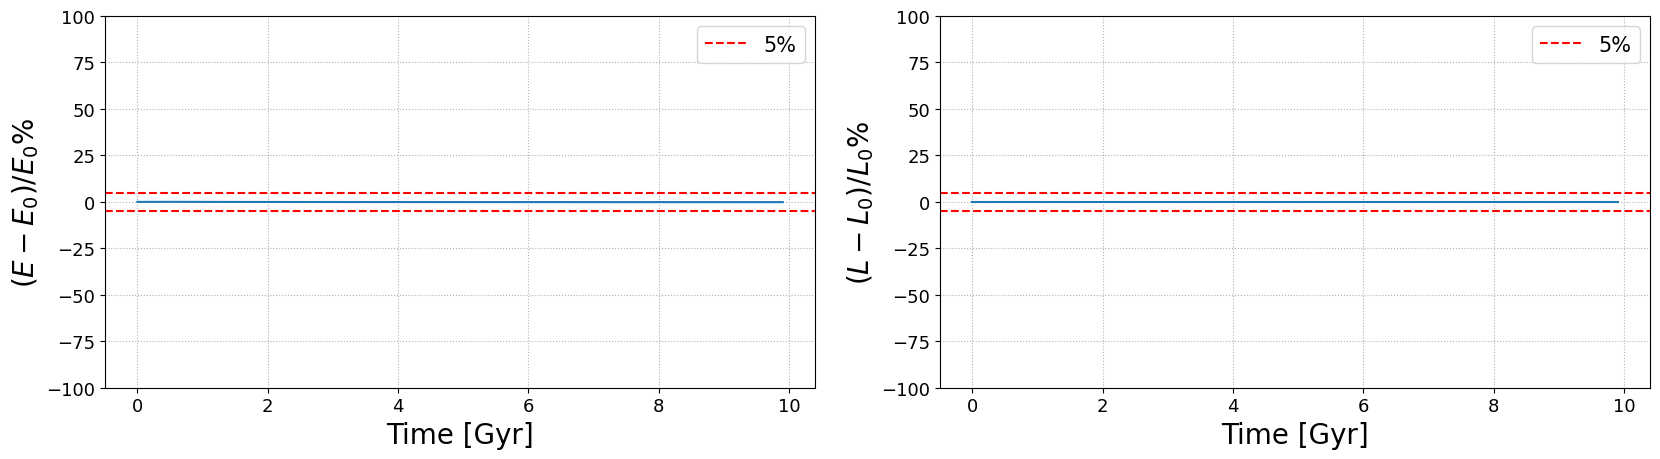

In [7]:
energy_angular_momentum_plot(snapshots, code_units, filename='./visualization/image/E_L_Plummer_in_NFWpotential.pdf')

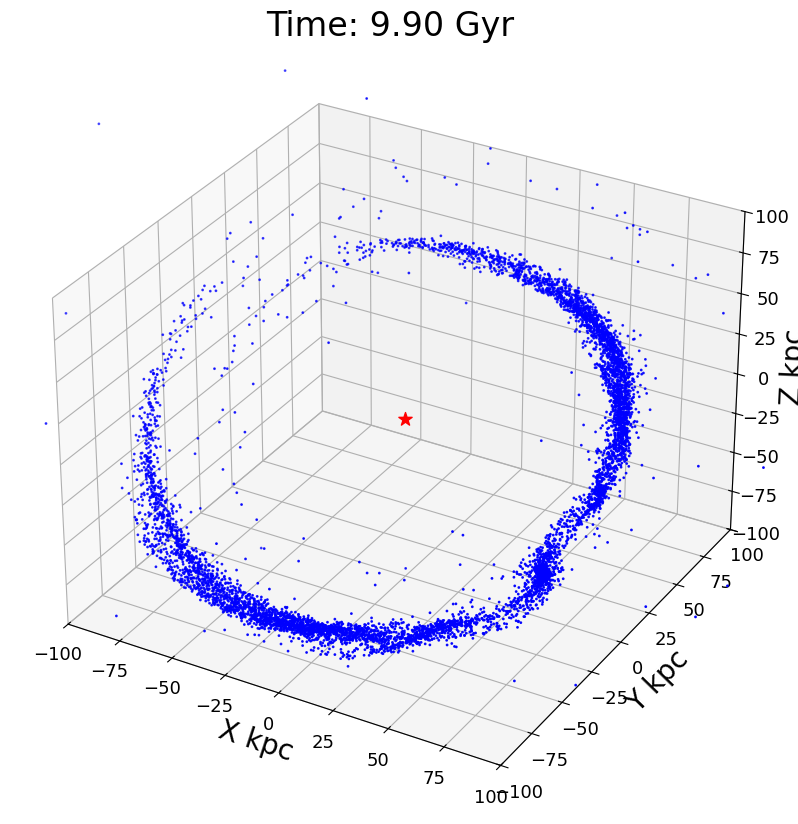

In [8]:
create_3d_gif(snapshots, 
              ax_lim=rp, 
              code_units=code_units, 
              plotting_units_length=u.kpc, 
              plot_units_time=u.Gyr, 
              filename='./visualization/gif/simulation_Plummer_in_NFWpotential.gif')

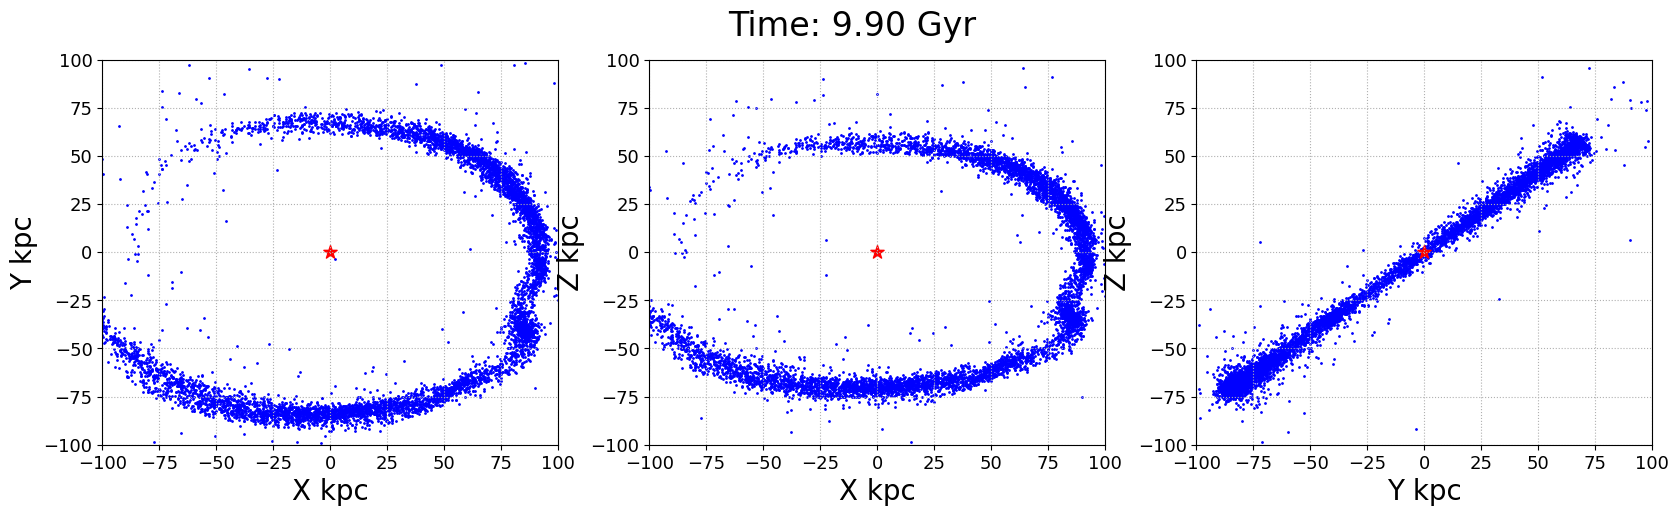

In [9]:
create_projection_gif(snapshots=snapshots,
                      ax_lim=rp, 
                      code_units=code_units, 
                      plotting_units_length=u.kpc, 
                      plot_units_time=u.Gyr, 
                      filename='./visualization/gif/simulation_projection_Plummer_in_NFWpotential.gif')

# Projection on the sky 

In [10]:

# Example: 3D Cartesian coordinates in kpc
x = snapshots.states[-1, :, 0, 0] * u.kpc
y = snapshots.states[-1, :, 0, 1] * u.kpc
z = snapshots.states[-1, :, 0, 2] * u.kpc

# Observer's position at (-8, 0, 0) kpc
x_obs, y_obs, z_obs = -8 * u.kpc, 0 * u.kpc, 0 * u.kpc

# Shift to observer's frame
x_rel = x - x_obs
y_rel = y - y_obs
z_rel = z - z_obs

# Convert to Galactic longitude l and latitude b
distance = np.sqrt(x_rel**2 + y_rel**2 + z_rel**2)
l = np.arctan2(y_rel, x_rel).to(u.deg)
b = np.arcsin(z_rel / distance).to(u.deg)

# Convert to Astropy SkyCoord object (if needed)
galactic_coords = SkyCoord(l=l, b=b, distance=distance, frame="galactic")

# Convert to Equatorial (RA, Dec) if needed
equatorial_coords = galactic_coords.transform_to("icrs")

# Get sky-plane projection
ra = equatorial_coords.ra
dec = equatorial_coords.dec

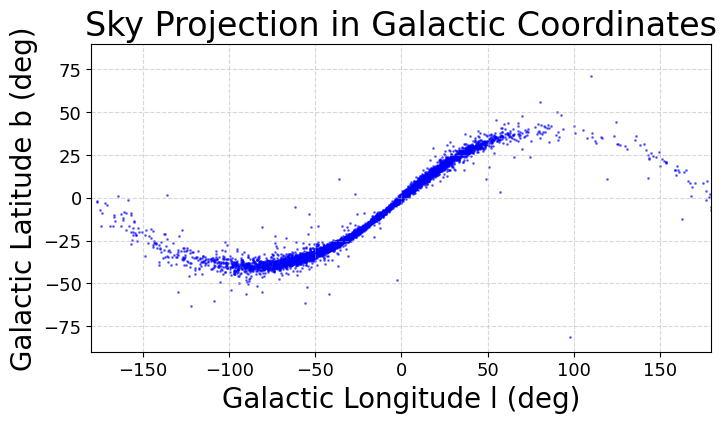

In [11]:
import matplotlib.pyplot as plt

# Convert longitude to range [-180, 180] for better visualization
l_wrap = (l + 180 * u.deg) % (360 * u.deg) - 180 * u.deg

plt.figure(figsize=(8, 4))
plt.scatter(l_wrap, b, s=1, color='blue', alpha=0.5)

plt.xlabel("Galactic Longitude l (deg)")
plt.ylabel("Galactic Latitude b (deg)")
plt.title("Sky Projection in Galactic Coordinates")
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


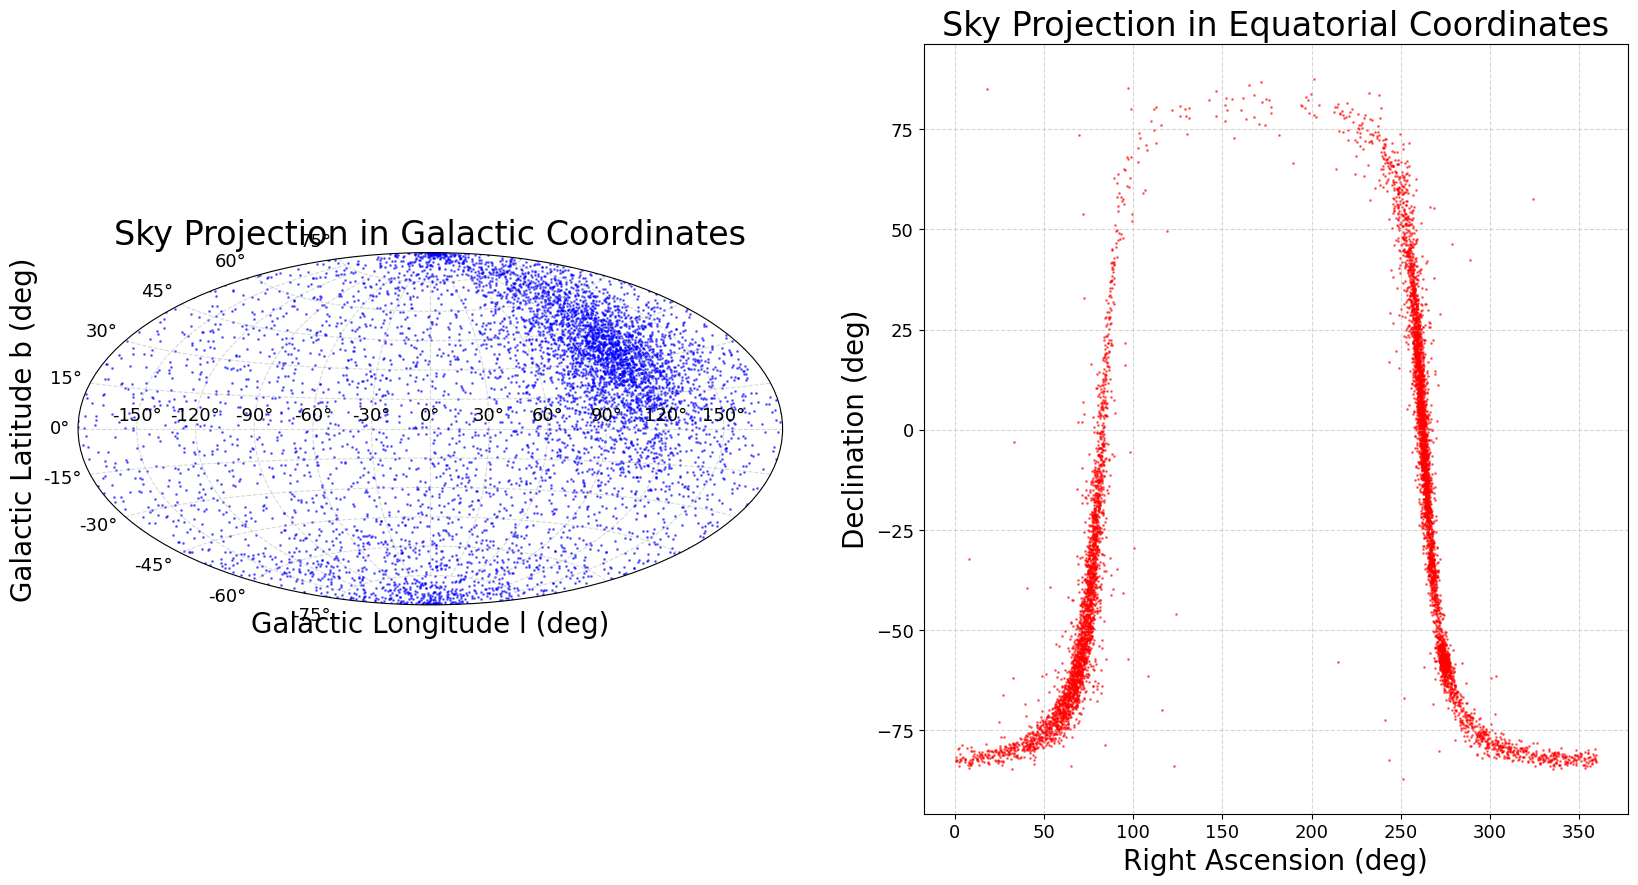

In [12]:
plot_sky_projection(snapshots=snapshots, code_units=code_units, plotting_units_length=u.kpc, filename=None)